__NOTE:__ For transforming the bboxes by albumentations library make sure you convert the bbox into 'coco' format which is [x_min, y_min, width, height], since it is the most stable. On repeated experimentation it was found that 'yolo' and 'pascal_voc' seems to be broken.

# Importing Library

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import selectivesearch
import os
from tqdm import tqdm
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters

In [2]:
img_aug_p = 0.5
iou_threshold = 0.4
img_crop_size = (224, 224)
img_resize_size = 256

# mean and std-dev taken from imagenet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

batch_size = 2
num_workers = 8

invTransform = transforms.Compose([transforms.Normalize(mean = [0., 0., 0.], std = [1/std[0], 1/std[1], 1/std[2]]),
                                  transforms.Normalize(mean = [-mean[0], -mean[1], -mean[2]], std = [1., 1., 1.])])

model_name = 'resnet50'
dropout_p = 0.4
num_epochs = 10
learning_rate = 1e-04
num_freeze = 100
freeze = True
lmb = 0.1

# Helper Functions

In [3]:
# Ref: https://albumentations.ai/docs/examples/example_bboxes/
def draw_bounding_boxes(image, bbox, category):
    x_1, y_1, x_2, y_2 = bbox
    x_1, y_1, x_2, y_2 = int(x_1), int(y_1), int(x_2), int(y_2)
    cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255, 0, 0), thickness=2, lineType = cv2.LINE_AA)
    ((text_width, text_height), _) = cv2.getTextSize(category, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(image, (x_1, y_1 - int(1.3 * text_height)), (x_1 + text_width, y_1), (0, 0, 0), -1)
    cv2.putText(image, category, (x_1, y_1 - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255))
    return image

def visualize_bbox(image, bboxes, category_idxs, idx_to_cat):
    img = image.copy()
    for bbox, category_idx in zip(bboxes, category_idxs):
        category = idx_to_cat[category_idx]
        img = draw_bounding_boxes(img, bbox, category)
    plt.figure(figsize = (8,8))
    plt.imshow(img)
    plt.axis('off')

def extract_regions(img, scale = 100):
    _, regions = selectivesearch.selective_search(img, scale = scale, min_size=100)
    candidates = []
    total_area = np.prod(img.shape[:2])
    for region in regions:
        if region['rect'] in candidates:
            continue
        # Remove rectangle which is less than 5% of total image area or greater than image
        elif region['size'] < (0.05*total_area):
            continue
        elif region['size'] > (1*total_area):
            continue
        candidates.append(region['rect'])
    return candidates

def calculate_iou(box_1, box_2, epsilon = 1e-06):
    iou = 0.0
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    x1_inter = max(box_1[0], box_2[0])
    y1_inter = max(box_1[1], box_2[1])
    x2_inter = min(box_1[2], box_2[2])
    y2_inter = min(box_1[3], box_2[3])
    inter_width = (x2_inter - x1_inter)
    inter_height = (y2_inter - y1_inter)
    if (inter_height < 0 or inter_width < 0):
        return 0.0
    inter_area = inter_width*inter_height
    union_area = box_1_area - box_2_area - inter_area
    iou = inter_area/(union_area + epsilon)
    return iou

# Loading Data and Visualization

In [4]:
base_folder = pathlib.Path('data/coco')
train_image_folder = base_folder/'train2017'
valid_image_folder = base_folder/'val2017'
train_csv = pd.read_csv(base_folder/'train.csv')
valid_csv = pd.read_csv(base_folder/'valid.csv')
train_csv['path'] = list(map(lambda x:train_image_folder/x, train_csv['file_name']))
# Transforming width and height column to width and height of the bounding box
train_csv['width'] = train_csv['x_2'].values - train_csv['x_1'].values
train_csv['height'] = train_csv['y_2'].values - train_csv['y_1'].values

# Valid
valid_csv['path'] = list(map(lambda x:valid_image_folder/x, valid_csv['file_name']))
# Transforming width and height column to width and height of the bounding box
valid_csv['width'] = valid_csv['x_2'].values - valid_csv['x_1'].values
valid_csv['height'] = valid_csv['y_2'].values - valid_csv['y_1'].values
train_csv.head()

,image_id,file_name,width,height,x_1,y_1,x_2,y_2,category_idx,category_name,path
0,9,000000000009.jpg,75,46,376,40,451,86,55,orange,data/coco/train2017/000000000009.jpg
1,9,000000000009.jpg,58,47,465,38,523,85,55,orange,data/coco/train2017/000000000009.jpg
2,9,000000000009.jpg,320,228,311,4,631,232,51,bowl,data/coco/train2017/000000000009.jpg
3,9,000000000009.jpg,316,245,249,229,565,474,56,broccoli,data/coco/train2017/000000000009.jpg
4,9,000000000009.jpg,94,71,364,2,458,73,55,orange,data/coco/train2017/000000000009.jpg


In [5]:
idx_to_cat = set(train_csv.groupby(['category_idx', 'category_name']).groups)
idx_to_cat = dict(idx_to_cat)
idx_to_cat[0] = 'background'
cat_to_idx = {v:k for k,v in idx_to_cat.items()}
print(idx_to_cat)

{35: 'skis', 3: 'car', 8: 'truck', 36: 'snowboard', 6: 'bus', 85: 'clock', 13: 'stop sign', 57: 'carrot', 61: 'cake', 43: 'tennis racket', 90: 'toothbrush', 2: 'bicycle', 22: 'elephant', 82: 'refrigerator', 63: 'couch', 60: 'donut', 86: 'vase', 65: 'bed', 7: 'train', 80: 'toaster', 23: 'bear', 9: 'boat', 75: 'remote', 10: 'traffic light', 18: 'dog', 25: 'giraffe', 34: 'frisbee', 54: 'sandwich', 48: 'fork', 17: 'cat', 84: 'book', 58: 'hot dog', 88: 'teddy bear', 62: 'chair', 42: 'surfboard', 31: 'handbag', 19: 'horse', 37: 'sports ball', 11: 'fire hydrant', 52: 'banana', 47: 'cup', 1: 'person', 73: 'laptop', 89: 'hair drier', 81: 'sink', 32: 'tie', 49: 'knife', 5: 'airplane', 16: 'bird', 39: 'baseball bat', 14: 'parking meter', 40: 'baseball glove', 41: 'skateboard', 33: 'suitcase', 44: 'bottle', 4: 'motorcycle', 28: 'umbrella', 59: 'pizza', 53: 'apple', 77: 'cell phone', 72: 'tv', 51: 'bowl', 27: 'backpack', 87: 'scissors', 79: 'oven', 15: 'bench', 76: 'keyboard', 46: 'wine glass', 38:

In [6]:
class COCOData(Dataset):
    def __init__(self, df, transforms = None):
        self.df = df
        self.unique_ids = df['image_id'].unique()
        self.transforms = transforms

    def __len__(self):
        return len(self.unique_ids)
    
    def __getitem__(self, idx):
        image_id = self.unique_ids[idx]
        df_sub = self.df[self.df['image_id'] == image_id]
        # Since all path are same for subset
        file_path = df_sub['path'].iloc[0]
        image = cv2.imread(str(file_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes = df_sub[['x_1', 'y_1', 'width', 'height']].values
        category_idx = df_sub['category_idx'].values.tolist()
        if self.transforms:
            transformed = self.transforms(image = image, bboxes = bboxes, category_idx=category_idx)
            image = transformed['image']
            bboxes = np.array(transformed['bboxes'])
        H, W = image.shape[:2]
        bboxes = np.hstack((bboxes[:, :2], bboxes[:, :2] + bboxes[:,2:]))

        # Extract proposed regions and compute pairwise iou with all the bbox present
        candidates = extract_regions(image)
        candidates = np.array([(x, y, x+w, y+h) for x,y,w,h in candidates])
        iou = np.array([[calculate_iou(bb, candidate) for bb in bboxes] for candidate in candidates])
        current_lbls, current_offsets, img_patches = [], [], []

        # Finding offset from the correct bounding boxes based on iou threshold
        for idx, candidate in enumerate(candidates):
            c_x_1, c_y_1, c_x_2, c_y_2 = candidate
            img_patch = image[c_y_1: c_y_2, c_x_1:c_x_2]
            img_patch = cv2.resize(img_patch, (224, 224))
            img_patches.append(img_patch)
            candidate_iou = iou[idx]
            best_iou = np.argmax(candidate_iou)
            iou_value = candidate_iou[best_iou]
            bbox = bboxes[best_iou]
            if iou_value > iou_threshold:
                current_lbls.append(category_idx[best_iou])
            else:
                current_lbls.append(0)

            # Make them in proportion to the image size
            current_offset = np.array([bbox[0] - c_x_1, bbox[1] - c_y_1, bbox[2] - c_x_2, bbox[3] - c_y_2]) / np.array([W, H, W, H])
            current_offsets.append(current_offset)

        # Building Tensor out of Data
        img_patches = np.array(img_patches)
        current_lbls = np.array(current_lbls)
        current_offsets = np.array(current_offsets)
        img_patches = torch.Tensor(img_patches)
        current_lbls = torch.Tensor(current_lbls).long()
        current_offsets = torch.Tensor(current_offsets).float()
        return img_patches, current_lbls, current_offsets
    
    def collate_function(self, batch):
        # Since images may have multiple number of patches, this'll make them all concatenated together
        final_inputs = []
        final_lbls = []
        final_offsets = []
        for current_batch in batch:
            final_inputs.append(current_batch[0])
            final_lbls.append(current_batch[1])
            final_offsets.append(current_batch[2])

        final_inputs = torch.permute(torch.cat(final_inputs), (0, 3, 1, 2))
        final_lbls = torch.cat(final_lbls)
        final_offsets = torch.cat(final_offsets)
        return final_inputs, final_lbls, final_offsets

In [7]:
train_transforms = A.Compose([A.HorizontalFlip(p = img_aug_p),
                              A.ShiftScaleRotate(p = img_aug_p),
                              A.LongestMaxSize(max_size= img_resize_size),
                              A.PadIfNeeded(img_resize_size, img_resize_size),
                              A.RandomCrop(*img_crop_size),
                              A.Normalize(mean, std, max_pixel_value=255.0),],
                              bbox_params=A.BboxParams('coco', label_fields=['category_idx']))

test_transforms = A.Compose([A.LongestMaxSize(max_size= img_resize_size),
                            A.RandomCrop(*img_crop_size),
                            A.Normalize(mean, std, max_pixel_value=255.0),],
                            bbox_params=A.BboxParams('coco', label_fields=['category_idx']))

train_coco = COCOData(train_csv, train_transforms)
valid_coco = COCOData(valid_csv, test_transforms)
train_loader = DataLoader(train_coco, batch_size=batch_size, num_workers = num_workers, drop_last=True, 
                          collate_fn=train_coco.collate_function)
test_loader = DataLoader(valid_coco, batch_size=batch_size, num_workers=num_workers, 
                         collate_fn=valid_coco.collate_function)

In [8]:
print(f"No of Train Images: {len(train_coco)}")
print(f"No of Test Images: {len(valid_coco)}")

No of Train Images: 117266
No of Test Images: 4952


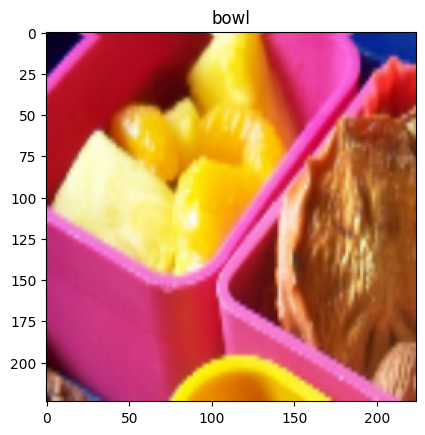

In [9]:
temp = next(iter(train_loader))
idx = 7
img = invTransform(temp[0][idx])
img = torch.permute(img, (1, 2, 0))
plt.imshow(img)
plt.title(idx_to_cat[temp[1][idx].item()]);

# Building Model

In [10]:
class RCNN(nn.Module):
    def __init__(self, base_model = 'resnet50', lmb = 0.1, freeze = True,
                 num_freeze = 100, dropout_p = 0.4, idx_to_cat = idx_to_cat):
        super(RCNN, self).__init__()
        model = timm.create_model(base_model, pretrained=True)
        lin_features = model.num_features
        layers = list(model.children())[:-1]
        layers.extend([nn.Linear(lin_features, 512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(dropout_p),
                        nn.Linear(512, 64),
                        nn.ReLU(),
                        nn.BatchNorm1d(64),
                        nn.Dropout(dropout_p)])
        
        # Backbone architecture
        self.feature_extractor = nn.Sequential(*layers)
        if freeze:
            self.freeze_layers(num_freeze)

        # Classifier
        self.categories = nn.Sequential(nn.Linear(64, len(idx_to_cat)))

        # Offset prediction
        self.offset = nn.Sequential(nn.Linear(64, 4),
                                    nn.Tanh())

        self.feature_extractor.apply(self.initialize_weights)
        self.categories.apply(self.initialize_weights)
        self.offset.apply(self.initialize_weights)

        # Initializing loss and its parameters
        self.lmb = lmb
        self.l1 = nn.L1Loss()
        self.cat_entropy = nn.CrossEntropyLoss()

    def initialize_weights(self, layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            layer.bias.data.fill_(0.0)

    def freeze_layers(self, num_freeze):
        for idx, param in enumerate(self.feature_extractor.parameters()):
            if idx <= num_freeze:
                param.requires_grad = False

    def forward(self, x):
        features = self.feature_extractor(x)
        cat = self.categories(features)
        off = self.offset(features)
        return cat, off
    
    def calculate_loss(self, cat_pred, offset_pred, cat_true, offset_true):
        cat_loss = self.cat_entropy(cat_pred, cat_true)
        idxs, _ = torch.where(cat_true != 0)
        offset_pred = offset_pred[idxs]
        offset_true = offset_true[idxs]
        regression_loss = 0.0
        if len(idxs) > 0:
            regression_loss = self.l1(offset_pred, offset_true)
        
        final_loss = regression_loss*self.lmb + cat_loss
        return final_loss, cat_loss, regression_loss

In [11]:
rcnn = RCNN(base_model=model_name, lmb = lmb, freeze=freeze, num_freeze=num_freeze, dropout_p=dropout_p, idx_to_cat=idx_to_cat)
rcnn = rcnn.to(device)
optimizer = optim.Adam(rcnn.parameters(), lr = learning_rate)
criterion = rcnn.calculate_loss
summary(rcnn, (3, 224, 224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64]                  --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         (75,008)
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         (70,400)
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         (70,400)
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         (379,392)
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         (280,064)
|    |    └─Bottleneck: 3-6              [-1,